## Lab Work 2 : Linear Regression

This notebook builds on the second lecture of Foundations of Machine Learning. We'll focus on the linear regression model.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.

## Introduction

In this sequence, we are trying to predict the price of the stock TSM : a taiwanese manufacturer of GPU chips, mostly used nowadays in AI. Let's have a look at the features we have to do it.

In [1]:
import pandas as pd

df = pd.read_csv("TSM.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.head()


,TSM,NVDA,MU,Gold,Silver,Platinium,Paladium,Copper
Date,,,,,,,,
2010-01-04,7.298709,0.423830,10.597220,1117.699951,17.440001,1517.300049,419.799988,3.3880
2010-01-05,7.267193,0.430019,10.909765,1118.099976,17.781000,1530.800049,420.350006,3.3960
2010-01-06,7.241982,0.432770,10.958601,1135.900024,18.163000,1552.199951,425.600006,3.4775
2010-01-07,7.002473,0.424289,10.587452,1133.099976,18.333000,1553.000000,422.950012,3.4115
2010-01-08,6.996171,0.425206,10.841397,1138.199951,18.458000,1564.599976,424.149994,3.3880


All of the above data comes from the [Yahoo Finance Python API](https://github.com/ranaroussi/yfinance). It gives access to all finance market data live listed on [Yahoo Finance](https://fr.finance.yahoo.com/). We choosed the daily close price of :
* **Companies** : Taiwan Semiconductor Manufacturing ([TSM](https://finance.yahoo.com/quote/TSM/)), Nvidia ([NVDA](https://finance.yahoo.com/quote/NVDA/)) and Micron Technology ([MU](https://finance.yahoo.com/quote/MU/))
* **Comodities** : Gold, Silver, Platinium, Paladium and Coppper. We couldn't get the silicon price because it is not freely available.

Our hypothese is that theses tickers can help use predict TSM's stock price. Let's have a look first at his price through time :



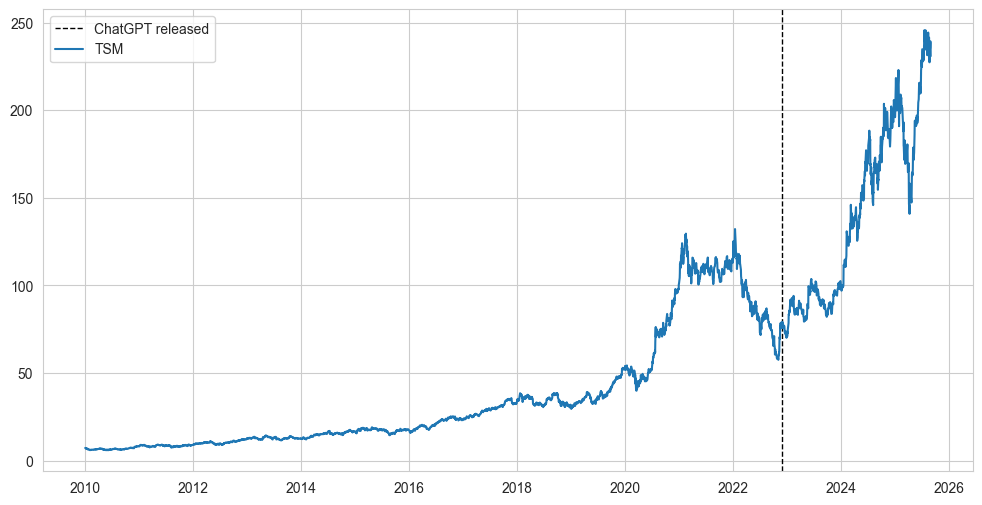

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.axvline(x=pd.to_datetime("2022-11-30"), ls='--', color="black", label="ChatGPT released", lw=1)
plt.plot(df["TSM"], label="TSM")
plt.legend()
plt.show()

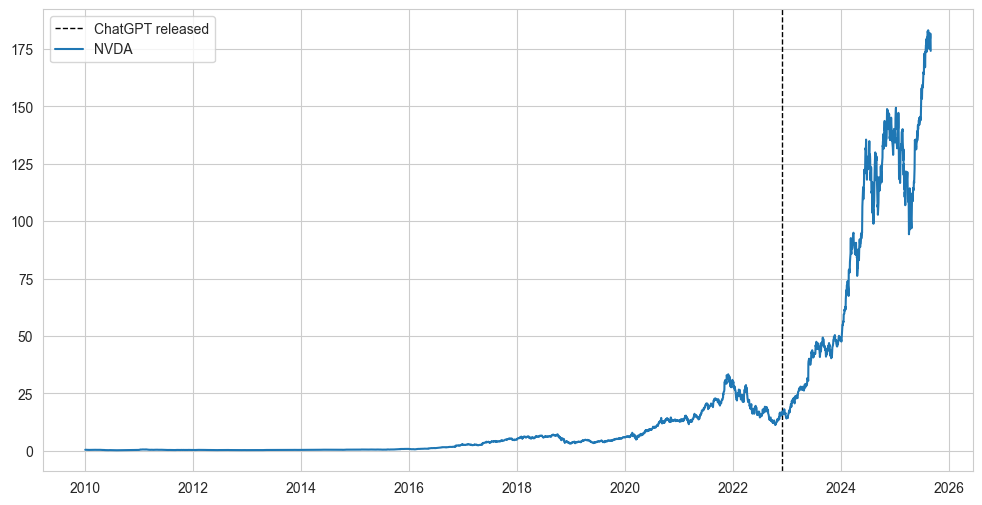

In [3]:
plt.figure(figsize=(12, 6))
plt.axvline(x=pd.to_datetime("2022-11-30"), ls='--', color="black", label="ChatGPT released", lw=1)
plt.plot(df["NVDA"], label="NVDA")
plt.legend()
plt.show()

## Data exploration

We need to go a bit deeper.

**Task** : Use the [`scatter_matrix`](https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html) function to start exploration relationship between all the columns.

array([[<Axes: xlabel='TSM', ylabel='TSM'>,
        <Axes: xlabel='NVDA', ylabel='TSM'>,
        <Axes: xlabel='MU', ylabel='TSM'>,
        <Axes: xlabel='Gold', ylabel='TSM'>,
        <Axes: xlabel='Silver', ylabel='TSM'>,
        <Axes: xlabel='Platinium', ylabel='TSM'>,
        <Axes: xlabel='Paladium', ylabel='TSM'>,
        <Axes: xlabel='Copper', ylabel='TSM'>],
       [<Axes: xlabel='TSM', ylabel='NVDA'>,
        <Axes: xlabel='NVDA', ylabel='NVDA'>,
        <Axes: xlabel='MU', ylabel='NVDA'>,
        <Axes: xlabel='Gold', ylabel='NVDA'>,
        <Axes: xlabel='Silver', ylabel='NVDA'>,
        <Axes: xlabel='Platinium', ylabel='NVDA'>,
        <Axes: xlabel='Paladium', ylabel='NVDA'>,
        <Axes: xlabel='Copper', ylabel='NVDA'>],
       [<Axes: xlabel='TSM', ylabel='MU'>,
        <Axes: xlabel='NVDA', ylabel='MU'>,
        <Axes: xlabel='MU', ylabel='MU'>,
        <Axes: xlabel='Gold', ylabel='MU'>,
        <Axes: xlabel='Silver', ylabel='MU'>,
        <Axes: xlabel='Platiniu

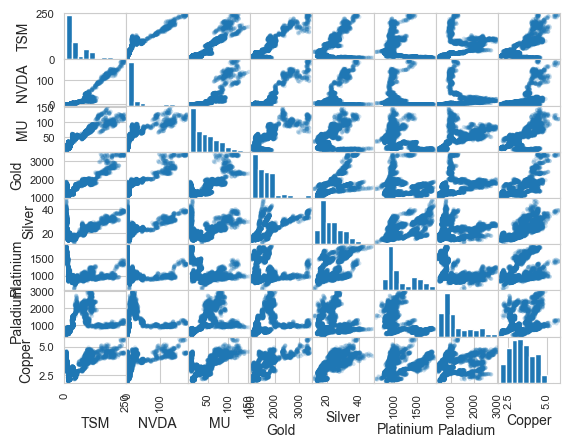

In [4]:
pd.plotting.scatter_matrix(df, alpha=0.2)

interpretation, if the scatter matrix shows a linear graph it is generally a good indicator to use it for a feature

**Task** : Use the [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function with the [`corr`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) method on the dataframe and plot the result.

<Axes: >

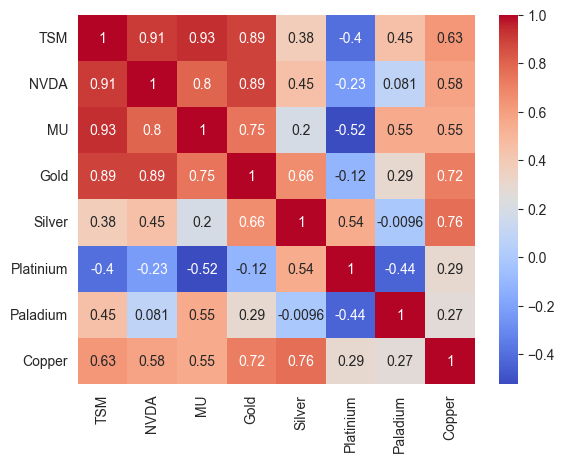

In [5]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")


**Task** : Given the previous cells, make a choice on which columns to keep.

In [6]:
df_useful = df[['TSM', 'NVDA', 'MU', 'Gold', 'Silver']]
df_useful.head()

,TSM,NVDA,MU,Gold,Silver
Date,,,,,
2010-01-04,7.298709,0.423830,10.597220,1117.699951,17.440001
2010-01-05,7.267193,0.430019,10.909765,1118.099976,17.781000
2010-01-06,7.241982,0.432770,10.958601,1135.900024,18.163000
2010-01-07,7.002473,0.424289,10.587452,1133.099976,18.333000
2010-01-08,6.996171,0.425206,10.841397,1138.199951,18.458000


## Feature engineering

Before we continue, we need to split the training and test set. In our setup, doing it randomly with [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) will lead to data leakage. Indeed, we might train on future data and test on data from the past, so we need to split according to time.

**Task** : Define a `train_test_time_splitting` function that split a matrix of feature *X* and a target vector *y* according to a *train_ratio*. 


In [7]:
from sklearn.model_selection import train_test_split

def train_test_time_splitting(X, y, train_ratio):
    """
    Split time series data chronologically.
    
    Args:
        X: Feature matrix
        y: Target vector
        train_ratio: Proportion of data for training (e.g., 0.6 for 60%)
    """
    split_idx = int(len(X) * train_ratio)
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    return X_train, X_test, y_train, y_test

    

In [8]:
X = df_useful[['NVDA', 'MU', 'Gold', 'Silver']]
y = df_useful['TSM']
y.head()

Date
2010-01-04    7.298709
2010-01-05    7.267193
2010-01-06    7.241982
2010-01-07    7.002473
2010-01-08    6.996171
Name: TSM, dtype: float64

In [9]:
train_ratio = 0.4
X_train, X_test, y_train, y_test = train_test_time_splitting(X, y, train_ratio)
X_test.head()

,NVDA,MU,Gold,Silver
Date,,,,
2016-04-08,0.873057,10.470248,1242.500000,15.382000
2016-04-11,0.878443,10.206539,1256.699951,15.974000
2016-04-12,0.877464,9.933063,1259.400024,16.219999
2016-04-13,0.899499,10.626519,1246.800049,16.323000
2016-04-14,0.901947,10.157703,1225.000000,16.169001


Now we need to build time series specific features. As we have daily closing price, we can't used them to predict *directly*. Instead, we can compute features based on the past values :

* **Lags** : the last value for a given period. One can use the [`shift`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) method for a vector.
* **Rolling** : the average or standard deviation of the previous values for a given period. One can use the [`rolling`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) method for a vector alongside the `mean` and `std` functions.
* **Return** : the evolution across a given period. One can use the [`pct_change`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) method for a vector.

**Task** : Define a function that build lags, rolling and return features (each being optionnal) for a dataframe and specifics columns. Also specify the periods length.



In [10]:
X_train

,NVDA,MU,Gold,Silver
Date,,,,
2010-01-04,0.423830,10.597220,1117.699951,17.440001
2010-01-05,0.430019,10.909765,1118.099976,17.781000
2010-01-06,0.432770,10.958601,1135.900024,18.163000
2010-01-07,0.424289,10.587452,1133.099976,18.333000
2010-01-08,0.425206,10.841397,1138.199951,18.458000
...,...,...,...,...
2016-04-01,0.885054,10.773027,1222.199951,15.042000
2016-04-04,0.876485,10.548387,1218.000000,14.942000
2016-04-05,0.875260,10.157703,1228.400024,15.114000


In [11]:
def lags(df, period):
    return df.shift(periods=period)


In [12]:
def rolling(df, window):
    return df.rolling(window).mean() 

**Task** : Use the previous function to compute rolling features of your choice.

In [13]:
rolling(X_train, 5)

,NVDA,MU,Gold,Silver
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN
2010-01-08,0.427223,10.778887,1128.599976,18.0350
...,...,...,...,...
2016-04-01,0.870413,10.315930,1227.759985,15.2278
2016-04-04,0.875163,10.397974,1227.379980,15.1774
2016-04-05,0.876925,10.388207,1225.939990,15.1528


In [14]:
def returns(df, period):
    return df.pct_change(periods=period)

In [15]:
returns(X_train, 2)

,NVDA,MU,Gold,Silver
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN
2010-01-06,0.021093,0.034101,0.016284,0.041456
2010-01-07,-0.013326,-0.029544,0.013416,0.031044
2010-01-08,-0.017479,-0.010695,0.002025,0.016242
...,...,...,...,...
2016-04-01,0.010906,0.052481,-0.003831,-0.010785
2016-04-04,0.004771,0.031519,-0.013126,-0.033506
2016-04-05,-0.011065,-0.057117,0.005073,0.004787


## Modelisation

Let's recap what we have learned so far, including the previous session :
1. A linear regression needs its input to be float and standardized : we use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to this end
2. It is easier to wrap the previous step with learning using a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
3. We need to split the dataset into train and test set according to time, using our own `train_test_time_splitting` function
4. We shall have a way to compare our work to a strong baseline. Here we will take the rolling average of TSM stock value in the last 7 days.


Common metrics to assess the performance of a regressor are, given a dataset of $n$ sample, ground truth vector $y$ and predicted values vector $\hat{y}$:
* **Root Mean Square Error** ([`RMSE`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html)) : penalize more large errors than MAE
$$ RMSE(y, \hat{y}) = \sqrt{\frac{1}{n} \sum_{k=1}^n (y_k - \hat{y}_k)^2}$$

* **Mean Absolute Error** ([`MAE`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)) : penalize smaller errors more than RMSE, all errors *weights* the same
$$ MAE(y, \hat{y}) = \frac{1}{n}\sum_{k=1}^n \left|y_k - \hat{y}_k\right|$$

* **[$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) Score** : bounded above by 1, gives insights on how well the model grasps the *structure*. Note that $R^2$ can be negative.
$$ R^2(y, \hat{y}) = 1 - \frac{\displaystyle \sum_{k=1}^n (y_k - \hat{y_k})^2}{\displaystyle \sum_{k=1}^n (y_k - \overline{y})^2}$$


**Task** : Define a function that takes a dataset with features, the target column and the features columns. Then the function will split, train and display performance on the test according to the three above metrics, and display the performance of the baseline.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def split_train_display_pipeline(df, y, features, train_ratio=0.6):
    """
    Properly handle feature engineering and scaling to prevent data leakage.
    """
    df = df.copy()
    
    # Step 1: Split FIRST (before any feature engineering)
    split_idx = int(len(df) * train_ratio)
    df_train = df.iloc[:split_idx].copy()
    df_test = df.iloc[split_idx:].copy()
    
    # Step 2: Apply rolling features SEPARATELY on train and test
    for feature in features:
        df_train[f"{feature}_rolling"] = df_train[feature].rolling(7).mean()
        df_test[f"{feature}_rolling"] = df_test[feature].rolling(7).mean()
    
    # Remove NaN values created by rolling
    df_train = df_train.dropna()
    df_test = df_test.dropna()
    
    # Step 3: Prepare X and y
    rolling_cols = [f"{f}_rolling" for f in features]
    X_train = df_train[rolling_cols]
    y_train = df_train[y]
    X_test = df_test[rolling_cols]
    y_test = df_test[y]
    
    # Step 4: Create pipeline with StandardScaler
    # The pipeline handles fit_transform and transform automatically!
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Learns from X_train, applies to both
        ('regressor', LinearRegression())
    ])
    
    # Step 5: Train (this uses fit_transform internally on X_train)
    pipeline.fit(X_train, y_train)
    
    # Step 6: Predict (this uses transform internally on X_test)
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Baseline: Use only training data for rolling average
    baseline_pred = df_test[y].rolling(7).mean()
    baseline_pred = baseline_pred.dropna()
    y_test_baseline = y_test.loc[baseline_pred.index]
    
    baseline_rmse = root_mean_squared_error(y_test_baseline, baseline_pred)
    baseline_mae = mean_absolute_error(y_test_baseline, baseline_pred)
    baseline_r2 = r2_score(y_test_baseline, baseline_pred)
    
    # Display results
    print("=" * 50)
    print(f"Features used: {features}")
    print("=" * 50)
    print("Linear Regression Model Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 50)
    print("Baseline (7-day Rolling Average) Performance:")
    print(f"RMSE: {baseline_rmse:.4f}")
    print(f"MAE: {baseline_mae:.4f}")
    print(f"R² Score: {baseline_r2:.4f}")
    print("=" * 50)
    
    return df_train, df_test

**Task** : use this function for our purpose using only TSM and NVDA rolling avg features.

In [17]:
test = split_train_display_pipeline(df, 'TSM', ['NVDA'], train_ratio=0.6)

test = split_train_display_pipeline(df, 'TSM', ['MU'], train_ratio=0.6)

test = split_train_display_pipeline(df, 'TSM', ['Gold'], train_ratio=0.6)

test = split_train_display_pipeline(df, 'TSM', ['Silver'], train_ratio=0.6)

test = split_train_display_pipeline(df, 'TSM', ['NVDA', 'MU', 'Gold', 'Silver'], train_ratio=0.6)


Features used: ['NVDA']
Linear Regression Model Performance:
RMSE: 200.6768
MAE: 117.9492
R² Score: -15.6915
--------------------------------------------------
Baseline (7-day Rolling Average) Performance:
RMSE: 3.5502
MAE: 2.4573
R² Score: 0.9948
Features used: ['MU']
Linear Regression Model Performance:
RMSE: 68.3158
MAE: 57.0353
R² Score: -0.9344
--------------------------------------------------
Baseline (7-day Rolling Average) Performance:
RMSE: 3.5502
MAE: 2.4573
R² Score: 0.9948
Features used: ['Gold']
Linear Regression Model Performance:
RMSE: 118.0148
MAE: 102.3277
R² Score: -4.5918
--------------------------------------------------
Baseline (7-day Rolling Average) Performance:
RMSE: 3.5649
MAE: 2.4643
R² Score: 0.9949
Features used: ['Silver']
Linear Regression Model Performance:
RMSE: 105.7180
MAE: 90.9434
R² Score: -3.4872
--------------------------------------------------
Baseline (7-day Rolling Average) Performance:
RMSE: 3.5649
MAE: 2.4643
R² Score: 0.9949
Features used:

Our model performs worse than the rolling average baseline, yet showing great metric performance. We need to improve our model.

## Doing better

**Task** : Run the following cell and analyze its output.

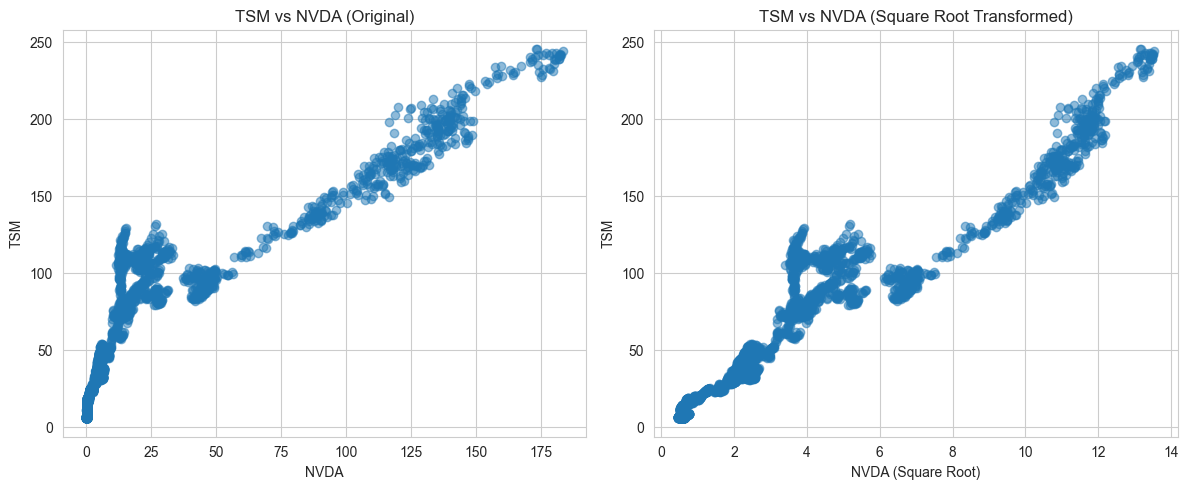

In [18]:
# Analyze relationship between TSM and NVDA
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['NVDA'], df['TSM'], alpha=0.5)
plt.xlabel('NVDA')
plt.ylabel('TSM')
plt.title('TSM vs NVDA (Original)')

plt.subplot(1, 2, 2)
plt.scatter(df['NVDA'] ** 0.5, df['TSM'], alpha=0.5)
plt.xlabel('NVDA (Square Root)')
plt.ylabel('TSM')
plt.title('TSM vs NVDA (Square Root Transformed)')

plt.tight_layout()
plt.show()

We see that the trend between TSM stock closing price and NVDA's are not linearly related, but they are with a root square ! Therefore, to *help* the linear model, we shall switch from *pure* NVDA's stock values to square root values. Obviously, one need to check that it works with all rolling average column related to NVIDIA.

**Task** : Implement the described idea. Then, train again a model using these features.

In [22]:
# Apply square root transformation to NVDA features
df_transformed = df.copy()
df_transformed['NVDA'] = df_transformed['NVDA'] ** 0.5

# Split and train with transformed NVDA feature
test_sqrt = split_train_display_pipeline(df_transformed, 'TSM', ['NVDA'], train_ratio=0.6)

Features used: ['NVDA']
Linear Regression Model Performance:
RMSE: 29.4040
MAE: 23.8171
R² Score: 0.6416
--------------------------------------------------
Baseline (7-day Rolling Average) Performance:
RMSE: 3.5502
MAE: 2.4573
R² Score: 0.9948


Now, this is better !

**Task** : Keep trying ideas to outperform even more the baseline.